# Bitcoin LSTM Tuning

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [7]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [8]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [9]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_count', 'bitcoin_polarity_zeros', 'bitcoin_polarity', 'bitcoin_subjectivity', 'bitcoin_subjectivity_zeros', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [10]:
timeperiod_df.iloc[0]

closePriceUsd    3.611949e+04
highPriceUsd     3.613191e+04
lowPriceUsd      3.544398e+04
volume           6.226012e+10
Name: 0, dtype: float64

In [11]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 4)
Target shape: (128, 1)


In [12]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [13]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [14]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 14s 630ms/step - loss: 0.5222 - val_loss: 0.5143
Epoch 2/20
13/13 [==============================] - 7s 513ms/step - loss: 0.2168 - val_loss: 0.3528
Epoch 3/20
13/13 [==============================] - 7s 564ms/step - loss: 0.1723 - val_loss: 0.3532
Epoch 4/20
13/13 [==============================] - 7s 511ms/step - loss: 0.1678 - val_loss: 0.3530
Epoch 5/20
13/13 [==============================] - 8s 641ms/step - loss: 0.1645 - val_loss: 0.3646
Epoch 6/20
13/13 [==============================] - 7s 583ms/step - loss: 0.1618 - val_loss: 0.4063
Epoch 7/20
13/13 [==============================] - 9s 719ms/step - loss: 0.1581 - val_loss: 0.2643
Epoch 8/20
13/13 [==============================] - 8s 605ms/step - loss: 0.1423 - val_loss: 0.1369
Epoch 9/20
13/13 [==============================] - 9s 706ms/step - loss: 0.1332 - val_loss: 0.5171
Epoch 10/20
13/13 [==============================] - 9s 740ms/step - loss: 0.1545 - val_loss: 0.253

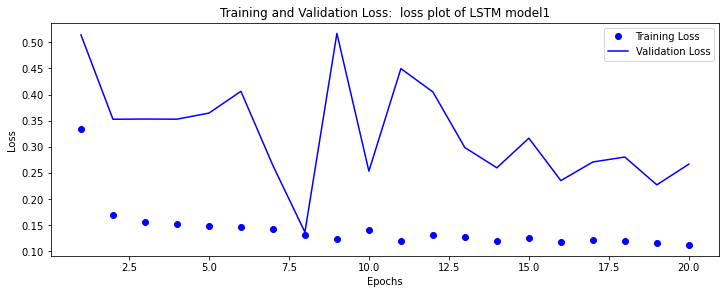

In [15]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 17s 717ms/step - loss: 0.4897 - val_loss: 0.5423
Epoch 2/20
13/13 [==============================] - 7s 571ms/step - loss: 0.2102 - val_loss: 0.3760
Epoch 3/20
13/13 [==============================] - 8s 597ms/step - loss: 0.1778 - val_loss: 0.3505
Epoch 4/20
13/13 [==============================] - 7s 535ms/step - loss: 0.1706 - val_loss: 0.4033
Epoch 5/20
13/13 [==============================] - 7s 569ms/step - loss: 0.1729 - val_loss: 0.4256
Epoch 6/20
13/13 [==============================] - 7s 557ms/step - loss: 0.1689 - val_loss: 0.3479
Epoch 7/20
13/13 [==============================] - 8s 601ms/step - loss: 0.1617 - val_loss: 0.4203
Epoch 8/20
13/13 [==============================] - 9s 622ms/step - loss: 0.1650 - val_loss: 0.4930
Epoch 9/20
13/13 [==============================] - 9s 663ms/step - loss: 0.1580 - val_loss: 0.6033
Epoch 10/20
13/13 [==============================] - 8s 656ms/step - loss: 0.1503 - val_loss: 0.117

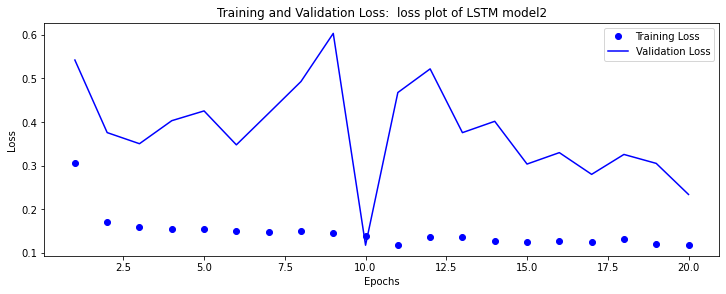

In [16]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 11s 622ms/step - loss: 0.3616 - val_loss: 0.5426
Epoch 2/20
13/13 [==============================] - 6s 420ms/step - loss: 0.2029 - val_loss: 0.4223
Epoch 3/20
13/13 [==============================] - 6s 467ms/step - loss: 0.1836 - val_loss: 0.3858
Epoch 4/20
13/13 [==============================] - 6s 500ms/step - loss: 0.1789 - val_loss: 0.3554
Epoch 5/20
13/13 [==============================] - 8s 637ms/step - loss: 0.1733 - val_loss: 0.3309
Epoch 6/20
13/13 [==============================] - 8s 611ms/step - loss: 0.1677 - val_loss: 0.3118
Epoch 7/20
13/13 [==============================] - 7s 550ms/step - loss: 0.1628 - val_loss: 0.2977
Epoch 8/20
13/13 [==============================] - 7s 572ms/step - loss: 0.1585 - val_loss: 0.2871
Epoch 9/20
13/13 [==============================] - 6s 443ms/step - loss: 0.1546 - val_loss: 0.2801
Epoch 10/20
13/13 [==============================] - 7s 538ms/step - loss: 0.1507 - val_loss: 0.281

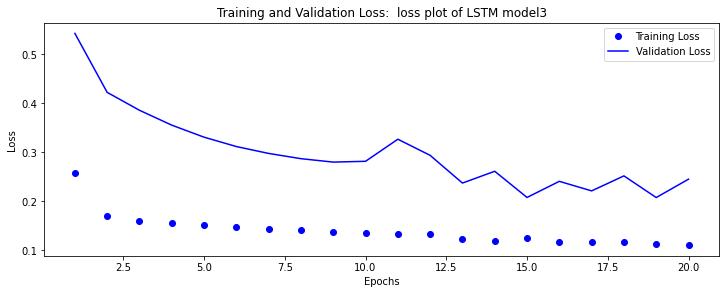

In [17]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 10s 522ms/step - loss: 0.3900 - val_loss: 0.4517
Epoch 2/20
13/13 [==============================] - 6s 476ms/step - loss: 0.1915 - val_loss: 0.3736
Epoch 3/20
13/13 [==============================] - 7s 585ms/step - loss: 0.1734 - val_loss: 0.3378
Epoch 4/20
13/13 [==============================] - 7s 458ms/step - loss: 0.1684 - val_loss: 0.3288
Epoch 5/20
13/13 [==============================] - 6s 503ms/step - loss: 0.1621 - val_loss: 0.3219
Epoch 6/20
13/13 [==============================] - 8s 651ms/step - loss: 0.1612 - val_loss: 0.3285
Epoch 7/20
13/13 [==============================] - 6s 467ms/step - loss: 0.1606 - val_loss: 0.2920
Epoch 8/20
13/13 [==============================] - 6s 448ms/step - loss: 0.1589 - val_loss: 0.2849
Epoch 9/20
13/13 [==============================] - 8s 564ms/step - loss: 0.1506 - val_loss: 0.2519
Epoch 10/20
13/13 [==============================] - 6s 426ms/step - loss: 0.1470 - val_loss: 0.255

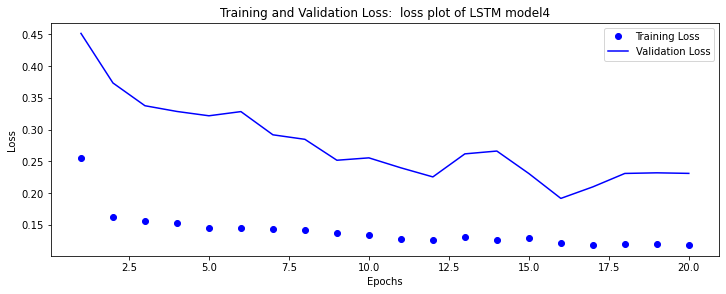

In [18]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 8s 426ms/step - loss: 0.3905 - val_loss: 0.5904
Epoch 2/30
13/13 [==============================] - 5s 356ms/step - loss: 0.2048 - val_loss: 0.4034
Epoch 3/30
13/13 [==============================] - 5s 380ms/step - loss: 0.1844 - val_loss: 0.3644
Epoch 4/30
13/13 [==============================] - 4s 339ms/step - loss: 0.1747 - val_loss: 0.3399
Epoch 5/30
13/13 [==============================] - 5s 350ms/step - loss: 0.1685 - val_loss: 0.3188
Epoch 6/30
13/13 [==============================] - 6s 514ms/step - loss: 0.1634 - val_loss: 0.2997
Epoch 7/30
13/13 [==============================] - 4s 349ms/step - loss: 0.1589 - val_loss: 0.2824
Epoch 8/30
13/13 [==============================] - 4s 306ms/step - loss: 0.1548 - val_loss: 0.2673
Epoch 9/30
13/13 [==============================] - 6s 475ms/step - loss: 0.1507 - val_loss: 0.2535
Epoch 10/30
13/13 [==============================] - 4s 303ms/step - loss: 0.1468 - val_loss: 0.2402

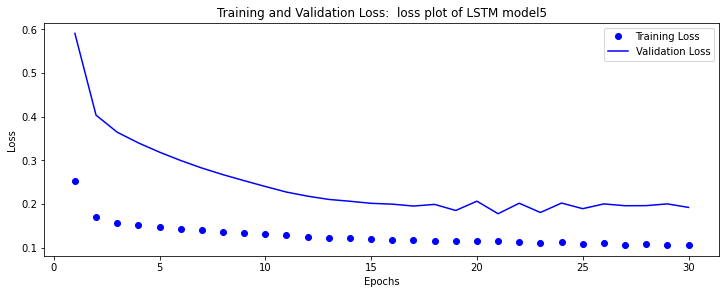

In [19]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 12s 427ms/step - loss: 0.2412 - val_loss: 0.4290
Epoch 2/20
13/13 [==============================] - 4s 339ms/step - loss: 0.1892 - val_loss: 0.3272
Epoch 3/20
13/13 [==============================] - 5s 359ms/step - loss: 0.1735 - val_loss: 0.2963
Epoch 4/20
13/13 [==============================] - 5s 429ms/step - loss: 0.1663 - val_loss: 0.2649
Epoch 5/20
13/13 [==============================] - 5s 401ms/step - loss: 0.1634 - val_loss: 0.2513
Epoch 6/20
13/13 [==============================] - 5s 399ms/step - loss: 0.1569 - val_loss: 0.2626
Epoch 7/20
13/13 [==============================] - 4s 346ms/step - loss: 0.1576 - val_loss: 0.2418
Epoch 8/20
13/13 [==============================] - 5s 424ms/step - loss: 0.1513 - val_loss: 0.2310
Epoch 9/20
13/13 [==============================] - 5s 404ms/step - loss: 0.1491 - val_loss: 0.2096
Epoch 10/20
13/13 [==============================] - 4s 335ms/step - loss: 0.1443 - val_loss: 0.215

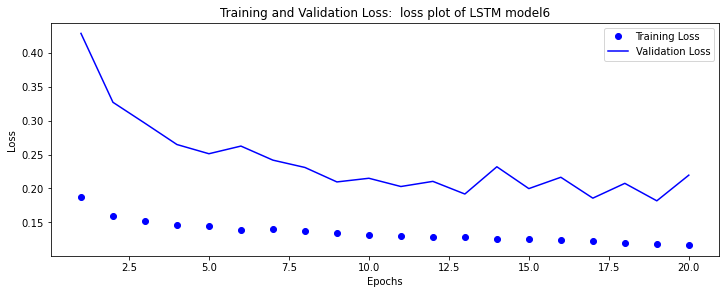

In [20]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 8s 402ms/step - loss: 0.3011 - val_loss: 0.3439
Epoch 2/30
13/13 [==============================] - 4s 331ms/step - loss: 0.1823 - val_loss: 0.2811
Epoch 3/30
13/13 [==============================] - 3s 270ms/step - loss: 0.1728 - val_loss: 0.2608
Epoch 4/30
13/13 [==============================] - 4s 290ms/step - loss: 0.1674 - val_loss: 0.2483
Epoch 5/30
13/13 [==============================] - 3s 270ms/step - loss: 0.1629 - val_loss: 0.2391
Epoch 6/30
13/13 [==============================] - 3s 251ms/step - loss: 0.1591 - val_loss: 0.2319
Epoch 7/30
13/13 [==============================] - 4s 313ms/step - loss: 0.1559 - val_loss: 0.2263
Epoch 8/30
13/13 [==============================] - 3s 243ms/step - loss: 0.1531 - val_loss: 0.2218
Epoch 9/30
13/13 [==============================] - 4s 276ms/step - loss: 0.1505 - val_loss: 0.2181
Epoch 10/30
13/13 [==============================] - 3s 240ms/step - loss: 0.1482 - val_loss: 0.2147

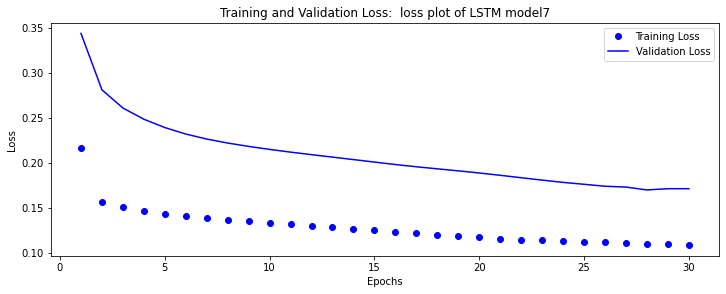

In [21]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 8s 368ms/step - loss: 0.2850 - val_loss: 0.5266
Epoch 2/20
13/13 [==============================] - 4s 333ms/step - loss: 0.1972 - val_loss: 0.3699
Epoch 3/20
13/13 [==============================] - 4s 325ms/step - loss: 0.1772 - val_loss: 0.3393
Epoch 4/20
13/13 [==============================] - 4s 319ms/step - loss: 0.1700 - val_loss: 0.3030
Epoch 5/20
13/13 [==============================] - 5s 436ms/step - loss: 0.1678 - val_loss: 0.2939
Epoch 6/20
13/13 [==============================] - 4s 303ms/step - loss: 0.1641 - val_loss: 0.2796
Epoch 7/20
13/13 [==============================] - 4s 288ms/step - loss: 0.1598 - val_loss: 0.2651
Epoch 8/20
13/13 [==============================] - 3s 262ms/step - loss: 0.1580 - val_loss: 0.2574
Epoch 9/20
13/13 [==============================] - 4s 313ms/step - loss: 0.1547 - val_loss: 0.2526
Epoch 10/20
13/13 [==============================] - 4s 302ms/step - loss: 0.1549 - val_loss: 0.2474

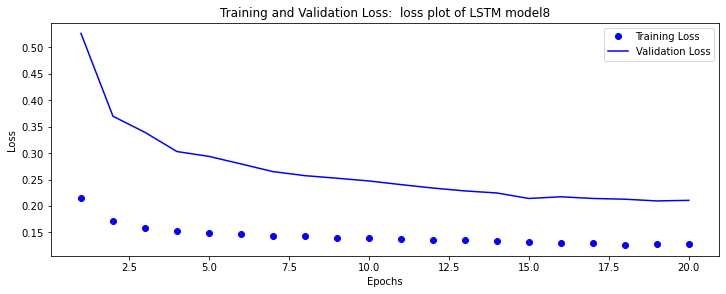

In [22]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 7s 292ms/step - loss: 0.5255 - val_loss: 0.2711
Epoch 2/30
13/13 [==============================] - 4s 346ms/step - loss: 0.2094 - val_loss: 0.2529
Epoch 3/30
13/13 [==============================] - 3s 224ms/step - loss: 0.1875 - val_loss: 0.2381
Epoch 4/30
13/13 [==============================] - 4s 286ms/step - loss: 0.1754 - val_loss: 0.2261
Epoch 5/30
13/13 [==============================] - 4s 286ms/step - loss: 0.1673 - val_loss: 0.2165
Epoch 6/30
13/13 [==============================] - 4s 298ms/step - loss: 0.1610 - val_loss: 0.2088
Epoch 7/30
13/13 [==============================] - 4s 262ms/step - loss: 0.1558 - val_loss: 0.2024
Epoch 8/30
13/13 [==============================] - 3s 229ms/step - loss: 0.1514 - val_loss: 0.1970
Epoch 9/30
13/13 [==============================] - 3s 239ms/step - loss: 0.1476 - val_loss: 0.1926
Epoch 10/30
13/13 [==============================] - 4s 322ms/step - loss: 0.1443 - val_loss: 0.1889

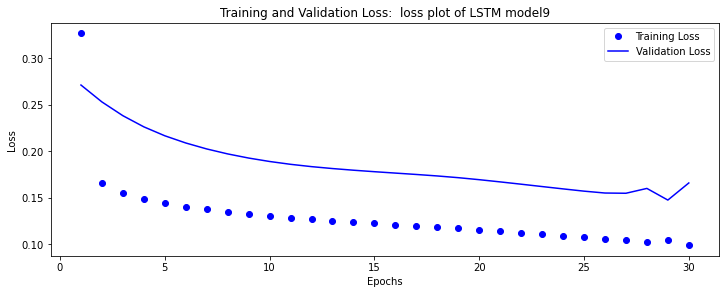

In [23]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 9s 387ms/step - loss: 0.3637 - val_loss: 0.2479
Epoch 2/20
13/13 [==============================] - 4s 331ms/step - loss: 0.1746 - val_loss: 0.2468
Epoch 3/20
13/13 [==============================] - 3s 258ms/step - loss: 0.1686 - val_loss: 0.2344
Epoch 4/20
13/13 [==============================] - 4s 262ms/step - loss: 0.1622 - val_loss: 0.2254
Epoch 5/20
13/13 [==============================] - 4s 307ms/step - loss: 0.1579 - val_loss: 0.2155
Epoch 6/20
13/13 [==============================] - 4s 295ms/step - loss: 0.1531 - val_loss: 0.2106
Epoch 7/20
13/13 [==============================] - 4s 279ms/step - loss: 0.1489 - val_loss: 0.2062
Epoch 8/20
13/13 [==============================] - 3s 242ms/step - loss: 0.1464 - val_loss: 0.1954
Epoch 9/20
13/13 [==============================] - 3s 237ms/step - loss: 0.1443 - val_loss: 0.1949
Epoch 10/20
13/13 [==============================] - 3s 260ms/step - loss: 0.1382 - val_loss: 0.1863

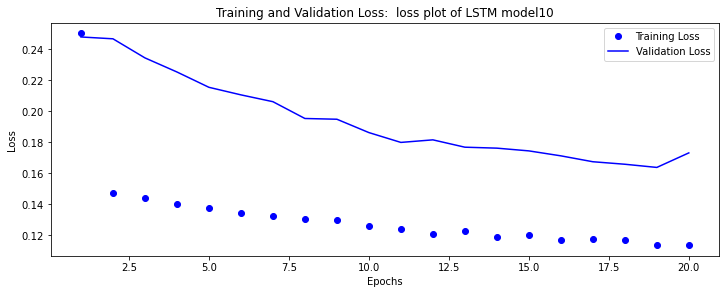

In [24]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 12s 443ms/step - loss: 0.4501 - val_loss: 0.1079
Epoch 2/50
13/13 [==============================] - 4s 258ms/step - loss: 0.3348 - val_loss: 0.1097
Epoch 3/50
13/13 [==============================] - 4s 277ms/step - loss: 0.2989 - val_loss: 0.1326
Epoch 4/50
13/13 [==============================] - 4s 294ms/step - loss: 0.2774 - val_loss: 0.1551
Epoch 5/50
13/13 [==============================] - 4s 285ms/step - loss: 0.2582 - val_loss: 0.1690
Epoch 6/50
13/13 [==============================] - 3s 277ms/step - loss: 0.2392 - val_loss: 0.1763
Epoch 7/50
13/13 [==============================] - 3s 266ms/step - loss: 0.2239 - val_loss: 0.1798
Epoch 8/50
13/13 [==============================] - 4s 288ms/step - loss: 0.2059 - val_loss: 0.1791
Epoch 9/50
13/13 [==============================] - 3s 235ms/step - loss: 0.1944 - val_loss: 0.1783
Epoch 10/50
13/13 [==============================] - 4s 334ms/step - loss: 0.1819 - val_loss: 0.176

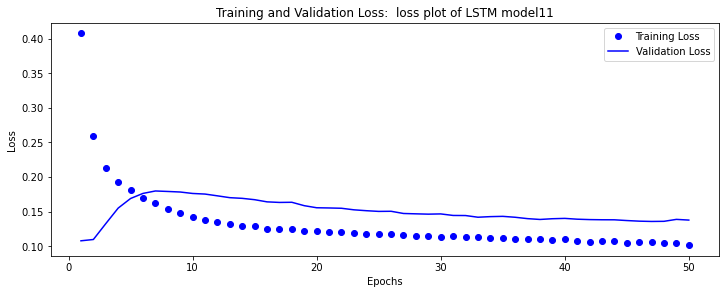

In [25]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 13s 592ms/step - loss: 0.4868 - val_loss: 0.6264
Epoch 2/20
13/13 [==============================] - 7s 540ms/step - loss: 0.2188 - val_loss: 0.5366
Epoch 3/20
13/13 [==============================] - 6s 426ms/step - loss: 0.2135 - val_loss: 0.5170
Epoch 4/20
13/13 [==============================] - 6s 491ms/step - loss: 0.2058 - val_loss: 0.4802
Epoch 5/20
13/13 [==============================] - 6s 482ms/step - loss: 0.1980 - val_loss: 0.4542
Epoch 6/20
13/13 [==============================] - 7s 515ms/step - loss: 0.1920 - val_loss: 0.4671
Epoch 7/20
13/13 [==============================] - 6s 437ms/step - loss: 0.1894 - val_loss: 0.4057
Epoch 8/20
13/13 [==============================] - 7s 559ms/step - loss: 0.1809 - val_loss: 0.4172
Epoch 9/20
13/13 [==============================] - 6s 481ms/step - loss: 0.1785 - val_loss: 0.3933
Epoch 10/20
13/13 [==============================] - 6s 489ms/step - loss: 0.1744 - val_loss: 0.381

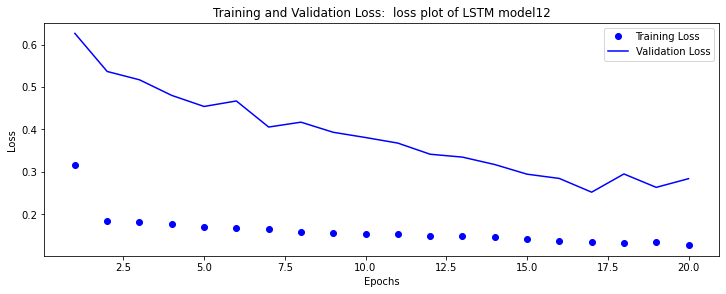

In [26]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 22s 857ms/step - loss: 0.3971 - val_loss: 1.2866
Epoch 2/20
13/13 [==============================] - 10s 778ms/step - loss: 0.2936 - val_loss: 0.8136
Epoch 3/20
13/13 [==============================] - 9s 734ms/step - loss: 0.2669 - val_loss: 0.7246
Epoch 4/20
13/13 [==============================] - 11s 853ms/step - loss: 0.2392 - val_loss: 0.6857
Epoch 5/20
13/13 [==============================] - 10s 788ms/step - loss: 0.2314 - val_loss: 0.6936
Epoch 6/20
13/13 [==============================] - 8s 597ms/step - loss: 0.2207 - val_loss: 0.6759
Epoch 7/20
13/13 [==============================] - 11s 865ms/step - loss: 0.2152 - val_loss: 0.6441
Epoch 8/20
13/13 [==============================] - 8s 654ms/step - loss: 0.2113 - val_loss: 0.6478
Epoch 9/20
13/13 [==============================] - 9s 718ms/step - loss: 0.2032 - val_loss: 0.6419
Epoch 10/20
13/13 [==============================] - 10s 769ms/step - loss: 0.1944 - val_loss: 

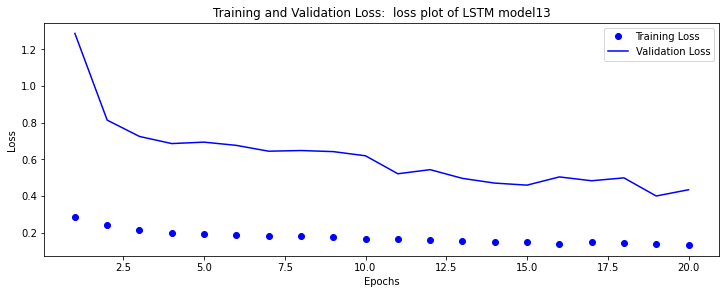

In [27]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 9s 450ms/step - loss: 0.2638 - val_loss: 0.4197
Epoch 2/20
13/13 [==============================] - 4s 278ms/step - loss: 0.1959 - val_loss: 0.3144
Epoch 3/20
13/13 [==============================] - 4s 282ms/step - loss: 0.1782 - val_loss: 0.2910
Epoch 4/20
13/13 [==============================] - 4s 339ms/step - loss: 0.1706 - val_loss: 0.2766
Epoch 5/20
13/13 [==============================] - 4s 298ms/step - loss: 0.1651 - val_loss: 0.2647
Epoch 6/20
13/13 [==============================] - 5s 431ms/step - loss: 0.1604 - val_loss: 0.2533
Epoch 7/20
13/13 [==============================] - 6s 446ms/step - loss: 0.1563 - val_loss: 0.2414
Epoch 8/20
13/13 [==============================] - 5s 353ms/step - loss: 0.1524 - val_loss: 0.2285
Epoch 9/20
13/13 [==============================] - 4s 281ms/step - loss: 0.1487 - val_loss: 0.2166
Epoch 10/20
13/13 [==============================] - 4s 293ms/step - loss: 0.1445 - val_loss: 0.2105

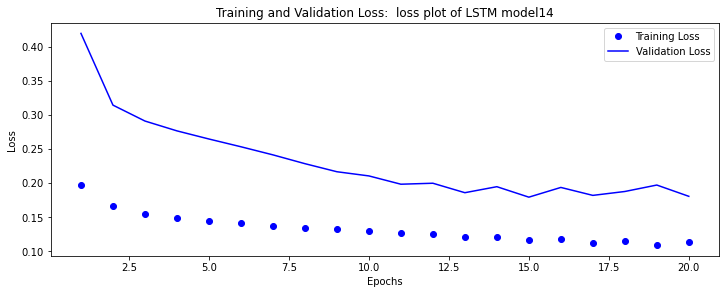

In [28]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 7s 357ms/step - loss: 0.6701 - val_loss: 0.1930
Epoch 2/40
13/13 [==============================] - 2s 187ms/step - loss: 0.2653 - val_loss: 0.2506
Epoch 3/40
13/13 [==============================] - 2s 191ms/step - loss: 0.2128 - val_loss: 0.2606
Epoch 4/40
13/13 [==============================] - 2s 193ms/step - loss: 0.1870 - val_loss: 0.2559
Epoch 5/40
13/13 [==============================] - 3s 206ms/step - loss: 0.1737 - val_loss: 0.2483
Epoch 6/40
13/13 [==============================] - 3s 253ms/step - loss: 0.1662 - val_loss: 0.2401
Epoch 7/40
13/13 [==============================] - 3s 216ms/step - loss: 0.1611 - val_loss: 0.2322
Epoch 8/40
13/13 [==============================] - 3s 197ms/step - loss: 0.1570 - val_loss: 0.2249
Epoch 9/40
13/13 [==============================] - 3s 199ms/step - loss: 0.1535 - val_loss: 0.2185
Epoch 10/40
13/13 [==============================] - 3s 197ms/step - loss: 0.1504 - val_loss: 0.2127

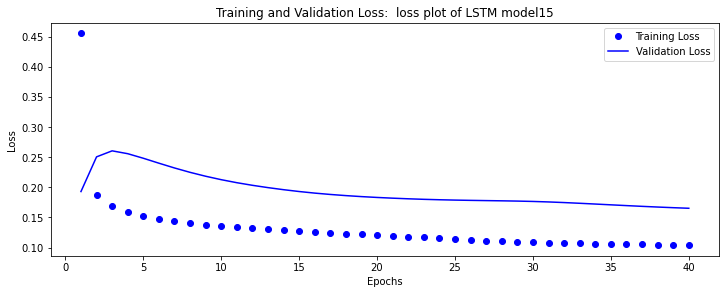

In [29]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 8s 401ms/step - loss: 0.5494 - val_loss: 0.6546
Epoch 2/20
13/13 [==============================] - 5s 408ms/step - loss: 0.2357 - val_loss: 0.4489
Epoch 3/20
13/13 [==============================] - 4s 344ms/step - loss: 0.1972 - val_loss: 0.4060
Epoch 4/20
13/13 [==============================] - 4s 347ms/step - loss: 0.1861 - val_loss: 0.3765
Epoch 5/20
13/13 [==============================] - 5s 380ms/step - loss: 0.1770 - val_loss: 0.3524
Epoch 6/20
13/13 [==============================] - 5s 417ms/step - loss: 0.1697 - val_loss: 0.3303
Epoch 7/20
13/13 [==============================] - 4s 335ms/step - loss: 0.1638 - val_loss: 0.3088
Epoch 8/20
13/13 [==============================] - 5s 403ms/step - loss: 0.1586 - val_loss: 0.2879
Epoch 9/20
13/13 [==============================] - 4s 343ms/step - loss: 0.1533 - val_loss: 0.2742
Epoch 10/20
13/13 [==============================] - 5s 354ms/step - loss: 0.1474 - val_loss: 0.2826

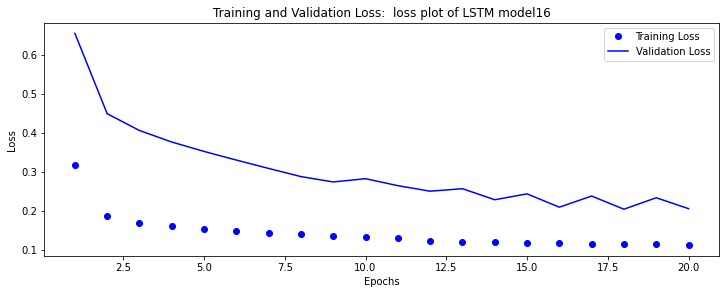

In [30]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 15s 635ms/step - loss: 0.4157 - val_loss: 0.7992
Epoch 2/30
13/13 [==============================] - 6s 451ms/step - loss: 0.2651 - val_loss: 0.5271
Epoch 3/30
13/13 [==============================] - 6s 461ms/step - loss: 0.2305 - val_loss: 0.4957
Epoch 4/30
13/13 [==============================] - 6s 435ms/step - loss: 0.2176 - val_loss: 0.4776
Epoch 5/30
13/13 [==============================] - 5s 368ms/step - loss: 0.2096 - val_loss: 0.4635
Epoch 6/30
13/13 [==============================] - 5s 385ms/step - loss: 0.2037 - val_loss: 0.4523
Epoch 7/30
13/13 [==============================] - 5s 402ms/step - loss: 0.1990 - val_loss: 0.4422
Epoch 8/30
13/13 [==============================] - 5s 376ms/step - loss: 0.1949 - val_loss: 0.4322
Epoch 9/30
13/13 [==============================] - 5s 378ms/step - loss: 0.1910 - val_loss: 0.4225
Epoch 10/30
13/13 [==============================] - 5s 369ms/step - loss: 0.1872 - val_loss: 0.413

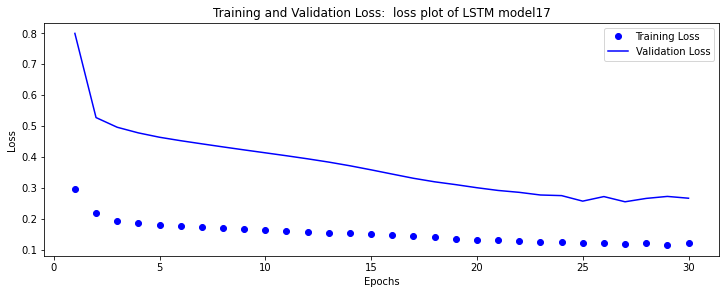

In [31]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 11s 403ms/step - loss: 0.3820 - val_loss: 0.6260
Epoch 2/30
13/13 [==============================] - 4s 332ms/step - loss: 0.2288 - val_loss: 0.4488
Epoch 3/30
13/13 [==============================] - 4s 316ms/step - loss: 0.2069 - val_loss: 0.4230
Epoch 4/30
13/13 [==============================] - 5s 384ms/step - loss: 0.1971 - val_loss: 0.4076
Epoch 5/30
13/13 [==============================] - 4s 307ms/step - loss: 0.1907 - val_loss: 0.3929
Epoch 6/30
13/13 [==============================] - 5s 360ms/step - loss: 0.1854 - val_loss: 0.3780
Epoch 7/30
13/13 [==============================] - 5s 354ms/step - loss: 0.1808 - val_loss: 0.3638
Epoch 8/30
13/13 [==============================] - 4s 308ms/step - loss: 0.1769 - val_loss: 0.3512
Epoch 9/30
13/13 [==============================] - 4s 313ms/step - loss: 0.1736 - val_loss: 0.3404
Epoch 10/30
13/13 [==============================] - 4s 337ms/step - loss: 0.1705 - val_loss: 0.330

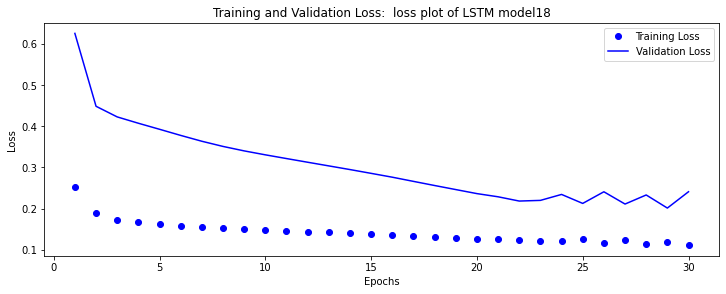

In [32]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [33]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.13693848252296448, epoch: 8
Model 2: min val loss: 0.11783771216869354, epoch: 10
Model 3: min val loss: 0.20777998864650726, epoch: 19
Model 4: min val loss: 0.19182610511779785, epoch: 16
Model 5: min val loss: 0.17793981730937958, epoch: 21
Model 6: min val loss: 0.18174037337303162, epoch: 19
Model 7: min val loss: 0.16965514421463013, epoch: 28
Model 8: min val loss: 0.2095969319343567, epoch: 19
Model 9: min val loss: 0.14736780524253845, epoch: 29
Model 10: min val loss: 0.16383840143680573, epoch: 19
Model 11: min val loss: 0.10785876959562302, epoch: 1
Model 12: min val loss: 0.2521853744983673, epoch: 17
Model 13: min val loss: 0.3998625576496124, epoch: 19
Model 14: min val loss: 0.17930655181407928, epoch: 15
Model 15: min val loss: 0.16525998711585999, epoch: 40
Model 16: min val loss: 0.2044508457183838, epoch: 18
Model 17: min val loss: 0.25483065843582153, epoch: 27
Model 18: min val loss: 0.20139306783676147, epoch: 29
